In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 500)

from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt 

import lightgbm as lgb

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

from datetime import timedelta

# Load data 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
(train.shape, test.shape)

((490513, 10), (518376, 8))

In [4]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


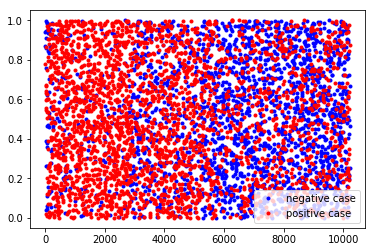

In [5]:
X = train[['cl_id','target_flag']].groupby('cl_id').agg('max').reset_index()
ind = X['target_flag']==0
plt.plot(X['cl_id'][ind], np.random.rand(np.sum(ind)), 'b.', label='negative case')
ind = X['target_flag']==1
plt.plot(X['cl_id'][ind], np.random.rand(np.sum(ind)), 'r.', label='positive case')
plt.legend()

In [6]:
# replace all missing values in 'channel_type' with new type 
train['channel_type'] = train['channel_type'].fillna('type0')
test['channel_type'] = test['channel_type'].fillna('type0')

### Working with currency rates 

In [7]:
# merge alph codes 
codes = pd.read_csv('./additional_data/codes-all.csv')
codes = codes[['NumericCode','AlphabeticCode']]
codes.columns = ['currency','AlphabeticCode']
codes = codes.dropna().reset_index(drop=True)
codes['currency'] = codes['currency'].astype('int')
codes = codes.drop_duplicates(subset=['currency']).reset_index(drop=True)
print(codes.shape)

train = pd.merge(train, codes, how='left', on = 'currency')
test = pd.merge(test, codes, how='left', on = 'currency')

(249, 2)


In [8]:
curr = pd.read_csv('./additional_data/curr.csv')
curr['CLOSE'] = curr['CLOSE'] / curr['NOMINAL']
curr = curr[['TICKER','DATE','CLOSE']]
curr.columns = ['AlphabeticCode','time','CLOSE']
curr['time'] = pd.to_datetime(curr['time'])

In [9]:
# drop outliers 
ts = train[['target_sum','cl_id']].groupby('cl_id').agg('max').reset_index()
t2s = train[['amount','cl_id']].groupby('cl_id').agg('max').reset_index()
ts = pd.merge(ts, t2s, how='left')
ouliers = list(ts[ts['target_sum']>np.exp(14)]['cl_id'])
train = train[~train['cl_id'].isin(ouliers)].reset_index(drop=True)

### Determine most freq MCC for each user 

In [10]:
def mode_count(x):
    return mode(x)[1][0][1]

train['MCC'] = train['MCC'].astype('int')
test['MCC'] = test['MCC'].astype('int')
    
d = train[['cl_id','MCC']].groupby('cl_id').apply(mode_count)
d = pd.DataFrame(d).reset_index()
d.columns = ['cl_id','mode_MCC']
train = pd.merge(train, d, how='left', on='cl_id')

d = test[['cl_id','MCC']].groupby('cl_id').apply(mode_count)
d = pd.DataFrame(d).reset_index()
d.columns = ['cl_id','mode_MCC']
test = pd.merge(test, d, how='left', on='cl_id')

### Transaction's remains

In [11]:
ostatok_cols = []
for i in [1,10,100,1000]:
    new_col = 'ostatok_'+str(i)
    ostatok_cols.append(new_col)
    train[new_col] = ((train['amount'] % i) == 0)*1
    test[new_col] = ((test['amount'] % i) == 0)*1

### Transaction amount into neg/pos values 

In [12]:
train['amount'] = -train['amount']
ind = (train['trx_category']=='C2C_IN') | (train['trx_category']=='DEPOSIT') | (train['trx_category']=='BACK_TRX')
train['amount'][ind] = abs(train['amount'][ind])

test['amount'] = -test['amount']
ind = (test['trx_category']=='C2C_IN') | (test['trx_category']=='DEPOSIT') | (test['trx_category']=='BACK_TRX')
test['amount'][ind] = abs(test['amount'][ind])

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [13]:
cat_cols = ['channel_type','trx_category']
for i in ['channel_type','trx_category']:
    le = LabelEncoder()
    le.fit( pd.concat([train[[i]], test[[i]]], axis=0) )
    train[i] = le.transform(train[i])
    test[i] = le.transform(test[i])

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
train.shape

(487163, 16)

### Deal with time cols 

In [15]:
dt_dict = {
    'JAN':'01',
    'FEB':'02',
    'MAR':'03',
    'APR':'04',
    'MAY':'05', 
    'JUN':'06',  
    'JUL':'07',
    'AUG':'08',
    'SEP':'09',
    'OCT':'10',
    'NOV':'11', 
    'DEC':'12',   
}


def dt_preprocess1(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    
    return '20'+str(year)+'-'+str(month)+'-'+str(day)

train['time'] = train['TRDATETIME'].apply(lambda x: dt_preprocess1(x))
train['time'] = pd.to_datetime(train['time'])
test['time'] = test['TRDATETIME'].apply(lambda x: dt_preprocess1(x))
test['time'] = pd.to_datetime(train['time'])

# ---------------------

def dt_preprocess(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    
    return '20'+str(year)+'-'+str(month)+'-'+str(day)+' '+str(hour)+":"+str(minute)+':'+str(second)

train['TRDATETIME'] = train['TRDATETIME'].apply(lambda x: dt_preprocess(x))
train['TRDATETIME'] = pd.to_datetime(train['TRDATETIME'])
test['TRDATETIME'] = test['TRDATETIME'].apply(lambda x: dt_preprocess(x))
test['TRDATETIME'] = pd.to_datetime(test['TRDATETIME'])

train['month'] = train['TRDATETIME'].dt.month + (train['TRDATETIME'].dt.year-2016)*12
test['month'] = test['TRDATETIME'].dt.month + (test['TRDATETIME'].dt.year-2016)*12

train['days_since2015'] = (train['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days
test['days_since2015'] = (test['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days

### Convert all to RUB

In [16]:
train = pd.merge(train, curr, how='left', on=['AlphabeticCode','time'])
train['CLOSE'] = train['CLOSE'].fillna(1)
train['amount'] = train['amount'] * train['CLOSE']
train = train.drop(['currency', 'AlphabeticCode', 'CLOSE','time'], axis=1)

test = pd.merge(test, curr, how='left', on=['AlphabeticCode','time'])
test['CLOSE'] = test['CLOSE'].fillna(1)
test['amount'] = test['amount'] * test['CLOSE']
test = test.drop(['currency', 'AlphabeticCode','CLOSE','time'], axis=1)

In [17]:
train.shape

(487163, 16)

# New features 

In [18]:
all_data = pd.concat([train.drop(['target_flag','target_sum'],axis=1),test], axis=0).reset_index(drop=True)
all_data = all_data.sort_values(by='TRDATETIME').reset_index(drop=True)

In [19]:
def uniq_len(x):
    return len(set(x))

deliv_cards = all_data[['cl_id','PERIOD']].groupby('PERIOD').agg(['count',uniq_len]).reset_index()
deliv_cards['PERIOD'] = pd.to_datetime(deliv_cards['PERIOD'], format='%d/%m/%Y')
deliv_cards.columns = ['TRDATETIME', 'num_deals_month', 'uniq_len_num_cards']
deliv_cards['TRDATETIME'] = deliv_cards['TRDATETIME'].dt.month + (deliv_cards['TRDATETIME'].dt.year-2016)*12
deliv_cards['avg_act'] = deliv_cards['num_deals_month'] / deliv_cards['uniq_len_num_cards']
deliv_cards.head(15)

,TRDATETIME,num_deals_month,uniq_len_num_cards,avg_act
0,13,94293,3241,29.093798
1,25,6003,268,22.399254
2,14,77724,3207,24.235734
3,26,5659,243,23.288066
4,15,70667,2944,24.003736
5,27,5396,186,29.010753
6,16,87937,2882,30.512491
7,28,87,50,1.740000
8,17,98036,3285,29.843531
9,18,108097,3567,30.304738


### num_deals

In [20]:
num_deals = all_data[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
num_deals.head()

,cl_id,num_deals
0,0,5
1,1,104
2,2,199
3,3,96
4,4,158


### sum_deals

In [21]:
sum_deals = all_data[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df = pd.merge(num_deals, sum_deals, how='left', on='cl_id')
sum_deals.head()

,cl_id,sum_deals
0,0,-24383.000000
1,1,-123548.016867
2,2,-319237.720000
3,3,-120848.770000
4,4,-348866.218582


In [22]:
def delta_minutes(x):
    return list(x.diff(1).dt.seconds/60)

delta_min = all_data[['cl_id','TRDATETIME']].groupby('cl_id').agg(delta_minutes).reset_index()

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanmin(x))
a.columns = ['cl_id', 'diff_TRDATETIME_min']
df = pd.merge(df, a, how='left', on='cl_id')

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanmax(x))
a.columns = ['cl_id', 'diff_TRDATETIME_max']
df = pd.merge(df, a, how='left', on='cl_id')

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanmean(x))
a.columns = ['cl_id', 'diff_TRDATETIME_mean']
df = pd.merge(df, a, how='left', on='cl_id')

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanstd(x))
a.columns = ['cl_id', 'diff_TRDATETIME_std']
df = pd.merge(df, a, how='left', on='cl_id')

a = delta_min.copy()
a['TRDATETIME'] = a['TRDATETIME'].apply(lambda x: np.nanmedian(x))
a.columns = ['cl_id', 'diff_TRDATETIME_median']
df = pd.merge(df, a, how='left', on='cl_id')

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: All-NaN axis encountered
  import sys
C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: All-NaN axis encountered
  if sys.path[0] == '':
C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [23]:
def diff_monthes(x):
    a = np.max(x) - np.min(x)
    return a.days

sum_deals = all_data[['cl_id','TRDATETIME']].groupby('cl_id').agg(diff_monthes).reset_index()
sum_deals.columns = ['cl_id','num_days_in_use']
df = pd.merge(df, sum_deals, how='left', on='cl_id')
sum_deals.head()

,cl_id,num_days_in_use
0,0,53
1,1,92
2,2,89
3,3,72
4,4,60


In [24]:
# fraction of monthes that been used = triger for 'empty transactions' monthes 
def len_div_set(x):
    return len(set(x)) / (np.max(x) - np.min(x) + 1)
sum_deals = all_data[['cl_id','days_since2015']].groupby('cl_id').agg(len_div_set).reset_index()
sum_deals.columns = ['cl_id','len_div_set_days']
df = pd.merge(df, sum_deals, how='left', on='cl_id')
sum_deals.head()

def len_set(x):
    return len(set(x)) 
sum_deals = all_data[['cl_id','days_since2015']].groupby('cl_id').agg(len_set).reset_index()
sum_deals.columns = ['cl_id','len_days']
df = pd.merge(df, sum_deals, how='left', on='cl_id')
sum_deals.head()

# another trigger for empty days
#def empy_montes_min(x):
#    return np.min(np.diff(np.unique(x)))

#sum_deals = all_data[['cl_id','days_since2015']].groupby('cl_id').agg(empy_montes_min).reset_index()
#sum_deals.columns = ['cl_id','empy_days_min']
#df = pd.merge(df, sum_deals, how='left', on='cl_id')

#def empy_montes_max(x):
#    return np.max(np.diff(np.unique(x)))

#sum_deals = all_data[['cl_id','days_since2015']].groupby('cl_id').agg(empy_montes_max).reset_index()
#sum_deals.columns = ['cl_id','empy_days_max']
#df = pd.merge(df, sum_deals, how='left', on='cl_id')

,cl_id,len_days
0,0,4
1,1,52
2,2,68
3,3,50
4,4,47


In [25]:
temp = all_data[['cl_id','TRDATETIME']].groupby('cl_id').agg('max').reset_index()
temp.columns = ['cl_id','max_TRDATETIME']
temp['max_TRDATETIME'] = temp['max_TRDATETIME'].dt.month + (temp['max_TRDATETIME'].dt.year-2016)*12
df = pd.merge(df, temp, how='left', on='cl_id')

temp = all_data[['cl_id','TRDATETIME']].groupby('cl_id').agg('min').reset_index()
temp.columns = ['cl_id','min_TRDATETIME']
temp['min_TRDATETIME'] = temp['min_TRDATETIME'].dt.month + (temp['min_TRDATETIME'].dt.year-2016)*12
df = pd.merge(df, temp, how='left', on='cl_id')

df['delta_month'] = df['max_TRDATETIME']-df['min_TRDATETIME']

# ---------- # 
deliv_cards.columns = ['max_TRDATETIME', 'max_month_num_deals', 'max_month_uniq_len_num_cards', 'max_month_avg_act']
df = pd.merge(df, deliv_cards, how='left', on='max_TRDATETIME')
deliv_cards.columns = ['min_TRDATETIME', 'min_month_num_deals', 'min_month_uniq_len_num_cards', 'min_month_avg_act']
df = pd.merge(df, deliv_cards, how='left', on='min_TRDATETIME')

### Merge df with cat cols 

In [26]:
def mmode(x):
    return mode(x)[0][0]

for i in tqdm(['channel_type', 'mode_MCC']):
    temp = all_data[['cl_id',i]].groupby('cl_id').agg(mmode).reset_index()
    
    temp = pd.DataFrame(temp.values)
    new_cols = ['cl_id',i]

    temp.columns = new_cols
    df = pd.merge(df, temp, how='left', on='cl_id')

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


### Different grby stats 

In [27]:
def mean_div_std(x):
    return np.mean(x)/(np.std(x)+1)

for i in tqdm(['month']):
    for k in ['median','max','min', mode_count, mmode]:
        temp = all_data[['cl_id',i]].groupby('cl_id').agg(k).reset_index()
        temp = pd.DataFrame(temp.values)
        temp.columns = ['cl_id', i+'_'+str(k)]
        df = pd.merge(df, temp, how='left', on='cl_id')

for i in tqdm(['amount']):
    for k in ['sum','mean','std','median','max','min', mode_count, mmode, mean_div_std]:
        temp = all_data[['cl_id',i]].groupby('cl_id').agg(k).reset_index()
        temp = pd.DataFrame(temp.values)
        temp.columns = ['cl_id', i+'_'+str(k)]
        df = pd.merge(df, temp, how='left', on='cl_id')
        
for i in tqdm(ostatok_cols):
    for k in ['mean','std','median','max','min',mean_div_std]:
        temp = all_data[['cl_id',i]].groupby('cl_id').agg(k).reset_index()
        temp = pd.DataFrame(temp.values)
        temp.columns = ['cl_id', i+'_'+str(k)]
        df = pd.merge(df, temp, how='left', on='cl_id')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.14s/it]


In [28]:
temp = all_data[['amount','month']].groupby('month').agg(['sum','mean','std','median',mean_div_std]).reset_index()
temp = pd.DataFrame(temp.values)
temp.columns = ['month_min', 'ag_month_sum','ag_month_mean','ag_month_std','ag_month_median','ag_month_mean_div_std']
df = pd.merge(df, temp, how='left', on='month_min')

temp.columns = ['month_max', 'ag_month_sum_max','ag_month_mean_max','ag_month_std_max','ag_month_median_max','ag_month_mean_div_std_max']
df = pd.merge(df, temp, how='left', on='month_max')

In [29]:
def mode_count(x):
    return mode(x)[1][0]

to_agg = ['sum','mean','std','median','max','min',mode_count,mmode,mean_div_std,'count']

for j in tqdm(pd.unique(train['trx_category'])):
    i = 'amount'
    temp = all_data[all_data['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df = pd.merge(df, temp, how='left', on='cl_id')
    #df[str(j)+'_'+i+'_'+'count_frac'] = df[str(j)+'_'+i+'_'+'count'] / df['num_deals']

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.80s/it]


### Last n days stats 

In [30]:
# determine day of last client action 
temp = all_data[['TRDATETIME','cl_id']].groupby('cl_id').agg('max').reset_index()
temp.columns = ['cl_id', 'last_action']
all_data = pd.merge(all_data, temp, how='left', on='cl_id')

# make new variable - last action minus n days 
delta_cols = []
for i in [7, 14, 30, 60]:
    new_col = 'last_action_minus_'+str(i)+'_days'
    delta_cols.append(new_col)
    all_data[new_col] = all_data['last_action'] - timedelta(days=i)

for i in tqdm(delta_cols):
    all_data[i] = all_data['TRDATETIME']>=all_data[i]
    temp = all_data[[i,'amount','cl_id']].groupby(['cl_id',i]).agg(to_agg).reset_index()
    temp = temp[temp[i]==True].reset_index(drop=True)
    temp = temp.drop(i,axis=1)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append(i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df = pd.merge(df, temp, how='left', on='cl_id')

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:14<00:00, 33.65s/it]


In [31]:
to_agg = ['sum','mean','std','median','max','min']

for k in to_agg:

    agg = ['last_action_minus_7_days_'+str(k), 'last_action_minus_14_days_'+str(k), 
       'last_action_minus_30_days_'+str(k), 'last_action_minus_60_days_'+str(k)]
    for i in range(len(agg)):
        df[agg[i]+str('_div_mean')] = df[agg[i]]/df['amount_'+str(k)]

    for i in range(0,len(agg)-1):
        for j in range(i+1,len(agg)):
            df[agg[i]+str('_div_')+str(agg[j])] = df[agg[i]] / df[agg[j]]
            df[agg[i]+str('_prc_')+str(agg[j])] = (df[agg[j]] - df[agg[i]]) / df[agg[j]]

In [32]:
agg = ['last_action_minus_7_days_count', 'last_action_minus_14_days_count', 
       'last_action_minus_30_days_count', 'last_action_minus_60_days_count']

for i in range(len(agg)):
    df[agg[i]+str('_div_mean')] = df[agg[i]]/df['num_deals']

for i in range(0,len(agg)-1):
    for j in range(i+1,len(agg)):
        df[agg[i]+str('_div_')+str(agg[j])] = df[agg[i]] / df[agg[j]]
        df[agg[i]+str('_prc_')+str(agg[j])] = (df[agg[j]] - df[agg[i]]) / df[agg[j]]

In [33]:
target = train[['target_flag', 'target_sum','cl_id']].groupby('cl_id').agg('max').reset_index()
df = pd.merge(df, target, on='cl_id', how='left')

In [34]:
df['cl_id'] = df['cl_id'].astype('int')

In [35]:
df['month_max'] = df['month_max'].astype('int')
df['month_min'] = df['month_min'].astype('int')

In [36]:
# df['deals_per_day'] = df['num_deals'] / (df['num_days_in_use'] + 1) -> low score 

In [37]:
train = df[df['target_flag'].isnull()==False].reset_index(drop=True)
test = df[df['target_flag'].isnull()==True].reset_index(drop=True)

In [38]:
train.shape

(4978, 324)

### Target enc for cat cols 

In [ ]:
## target encoding 
# this part of code is little bit leaky, which is fine for baseline solution 
# if you want to rely on your CV scores (why would not you, right?) check this: 
# https://youtu.be/g335THJxkto
# https://gist.github.com/ohld/ebee1656316a76026945caf5a571195e

for i in ['mode_MCC', 'channel_type']:
    d = train[['target_flag',i]].groupby(i).agg('mean')['target_flag'].to_dict()
    train[i] = train[i].replace(d)
    test[i] = test[i].replace(d)

### Clean train & test df 

In [40]:
# del cols with 1 uniq value 
features_q = train.shape[1]
feat = train.nunique()
non_unique = feat[feat < 2].index
train = train.drop(non_unique,axis=1)
test = test.drop(non_unique,axis=1)

In [41]:
train.head()

,cl_id,num_deals,sum_deals,diff_TRDATETIME_min,diff_TRDATETIME_max,diff_TRDATETIME_mean,diff_TRDATETIME_std,diff_TRDATETIME_median,num_days_in_use,len_div_set_days,len_days,max_TRDATETIME,min_TRDATETIME,delta_month,max_month_num_deals,max_month_uniq_len_num_cards,max_month_avg_act,min_month_num_deals,min_month_uniq_len_num_cards,min_month_avg_act,channel_type,mode_MCC,month_median,month_max,month_min,month_<function mode_count at 0x0000025BC32C0BF8>,month_<function mmode at 0x0000025BC32EB9D8>,amount_sum,amount_mean,amount_std,amount_median,amount_max,amount_min,amount_<function mode_count at 0x0000025BC32C0BF8>,amount_<function mmode at 0x0000025BC32EB9D8>,amount_<function mean_div_std at 0x0000025BC32DF2F0>,ostatok_1_mean,ostatok_1_std,ostatok_1_median,ostatok_1_max,ostatok_1_min,ostatok_1_<function mean_div_std at 0x0000025BC32DF2F0>,ostatok_10_mean,ostatok_10_std,ostatok_10_median,ostatok_10_max,ostatok_10_min,ostatok_10_<function mean_div_std at 0x0000025BC32DF2F0>,ostatok_100_mean,ostatok_100_std,ostatok_100_median,ostatok_100_max,ostatok_100_min,ostatok_100_<function mean_div_std at 0x0000025BC32DF2F0>,ostatok_1000_mean,ostatok_1000_std,ostatok_1000_median,ostatok_1000_max,ostatok_1000_min,ostatok_1000_<function mean_div_std at 0x0000025BC32DF2F0>,ag_month_sum,ag_month_mean,ag_month_std,ag_month_median,ag_month_mean_div_std,ag_month_sum_max,ag_month_mean_max,ag_month_std_max,ag_month_median_max,ag_month_mean_div_std_max,trx_category6_amount_sum,trx_category6_amount_mean,trx_category6_amount_std,trx_category6_amount_median,trx_category6_amount_max,trx_category6_amount_min,trx_category6_amount_<function mode_count at 0x0000025BD56A5D90>,trx_category6_amount_<function mmode at 0x0000025BC32EB9D8>,trx_category6_amount_<function mean_div_std at 0x0000025BC32DF2F0>,trx_category6_amount_count,trx_category5_amount_sum,trx_category5_amount_mean,trx_category5_amount_std,trx_category5_amount_median,trx_category5_amount_max,trx_category5_amount_min,trx_category5_amount_<function mode_count at 0x0000025BD56A5D90>,trx_category5_amount_<function mmode at 0x0000025BC32EB9D8>,trx_category5_amount_<function mean_div_std at 0x0000025BC32DF2F0>,trx_category5_amount_count,trx_category2_amount_sum,trx_category2_amount_mean,trx_category2_amount_std,trx_category2_amount_median,trx_category2_amount_max,trx_category2_amount_min,trx_category2_amount_<function mode_count at 0x0000025BD56A5D90>,trx_category2_amount_<function mmode at 0x0000025BC32EB9D8>,trx_category2_amount_<function mean_div_std at 0x0000025BC32DF2F0>,trx_category2_amount_count,trx_category9_amount_sum,trx_category9_amount_mean,trx_category9_amount_std,trx_category9_amount_median,trx_category9_amount_max,trx_category9_amount_min,trx_category9_amount_<function mode_count at 0x0000025BD56A5D90>,trx_category9_amount_<function mmode at 0x0000025BC32EB9D8>,trx_category9_amount_<function mean_div_std at 0x0000025BC32DF2F0>,trx_category9_amount_count,trx_category0_amount_sum,trx_category0_amount_mean,trx_category0_amount_std,trx_category0_amount_median,trx_category0_amount_max,trx_category0_amount_min,trx_category0_amount_<function mode_count at 0x0000025BD56A5D90>,trx_category0_amount_<function mmode at 0x0000025BC32EB9D8>,trx_category0_amount_<function mean_div_std at 0x0000025BC32DF2F0>,trx_category0_amount_count,trx_category8_amount_sum,trx_category8_amount_mean,trx_category8_amount_std,trx_category8_amount_median,trx_category8_amount_max,trx_category8_amount_min,trx_category8_amount_<function mode_count at 0x0000025BD56A5D90>,trx_category8_amount_<function mmode at 0x0000025BC32EB9D8>,trx_category8_amount_<function mean_div_std at 0x0000025BC32DF2F0>,trx_category8_amount_count,trx_category7_amount_sum,trx_category7_amount_mean,trx_category7_amount_std,trx_category7_amount_median,trx_category7_amount_max,trx_category7_amount_min,trx_category7_amount_<function mode_count at 0x0000025BD56A5D90>,trx_category7_amount_<function mmode at 0x0000025BC32EB9D8>,trx_category7_amount_<function m

## model 

In [42]:
from sklearn.model_selection import RepeatedStratifiedKFold
skf = RepeatedStratifiedKFold(n_splits=8, n_repeats=5, random_state=201805)

In [43]:
lgb_data_train = lgb.Dataset(train.drop(['target_flag','target_sum'],axis=1), 
                             train['target_flag'], 
                             free_raw_data=False
                            )

params = {
    'objective':'binary', 
    'metric': 'auc',
    'learning_rate': 0.01, 
    'random_state':4242442,
    'subsample':0.33,
    'class_weight':'balanced',
    'colsample_bytree':0.33,
    'reg_lambda':4
}

h = lgb.cv(params, 
           lgb_data_train, 
           num_boost_round=10000,
           early_stopping_rounds=50, 
           verbose_eval=10, 
           folds=skf.split(train, train['target_flag'])
          )

[10]	cv_agg's auc: 0.855213 + 0.0128273
[20]	cv_agg's auc: 0.86025 + 0.0122482
[30]	cv_agg's auc: 0.860474 + 0.0123408
[40]	cv_agg's auc: 0.861221 + 0.0122986
[50]	cv_agg's auc: 0.862063 + 0.0123509
[60]	cv_agg's auc: 0.862644 + 0.0122585
[70]	cv_agg's auc: 0.863217 + 0.0122152
[80]	cv_agg's auc: 0.863095 + 0.0122729
[90]	cv_agg's auc: 0.863185 + 0.0121954
[100]	cv_agg's auc: 0.863486 + 0.0120977
[110]	cv_agg's auc: 0.863727 + 0.0121169
[120]	cv_agg's auc: 0.864309 + 0.0121799
[130]	cv_agg's auc: 0.864664 + 0.0121934
[140]	cv_agg's auc: 0.865063 + 0.0122388
[150]	cv_agg's auc: 0.865601 + 0.0121307
[160]	cv_agg's auc: 0.865718 + 0.0120591
[170]	cv_agg's auc: 0.866319 + 0.0119521
[180]	cv_agg's auc: 0.866667 + 0.0119513
[190]	cv_agg's auc: 0.86716 + 0.0119502
[200]	cv_agg's auc: 0.867384 + 0.0120001
[210]	cv_agg's auc: 0.867761 + 0.0119868
[220]	cv_agg's auc: 0.86827 + 0.0118619
[230]	cv_agg's auc: 0.868573 + 0.0118801
[240]	cv_agg's auc: 0.868814 + 0.0118758
[250]	cv_agg's auc: 0.869167

In [44]:
model = lgb.train(params, lgb_data_train, num_boost_round=660)

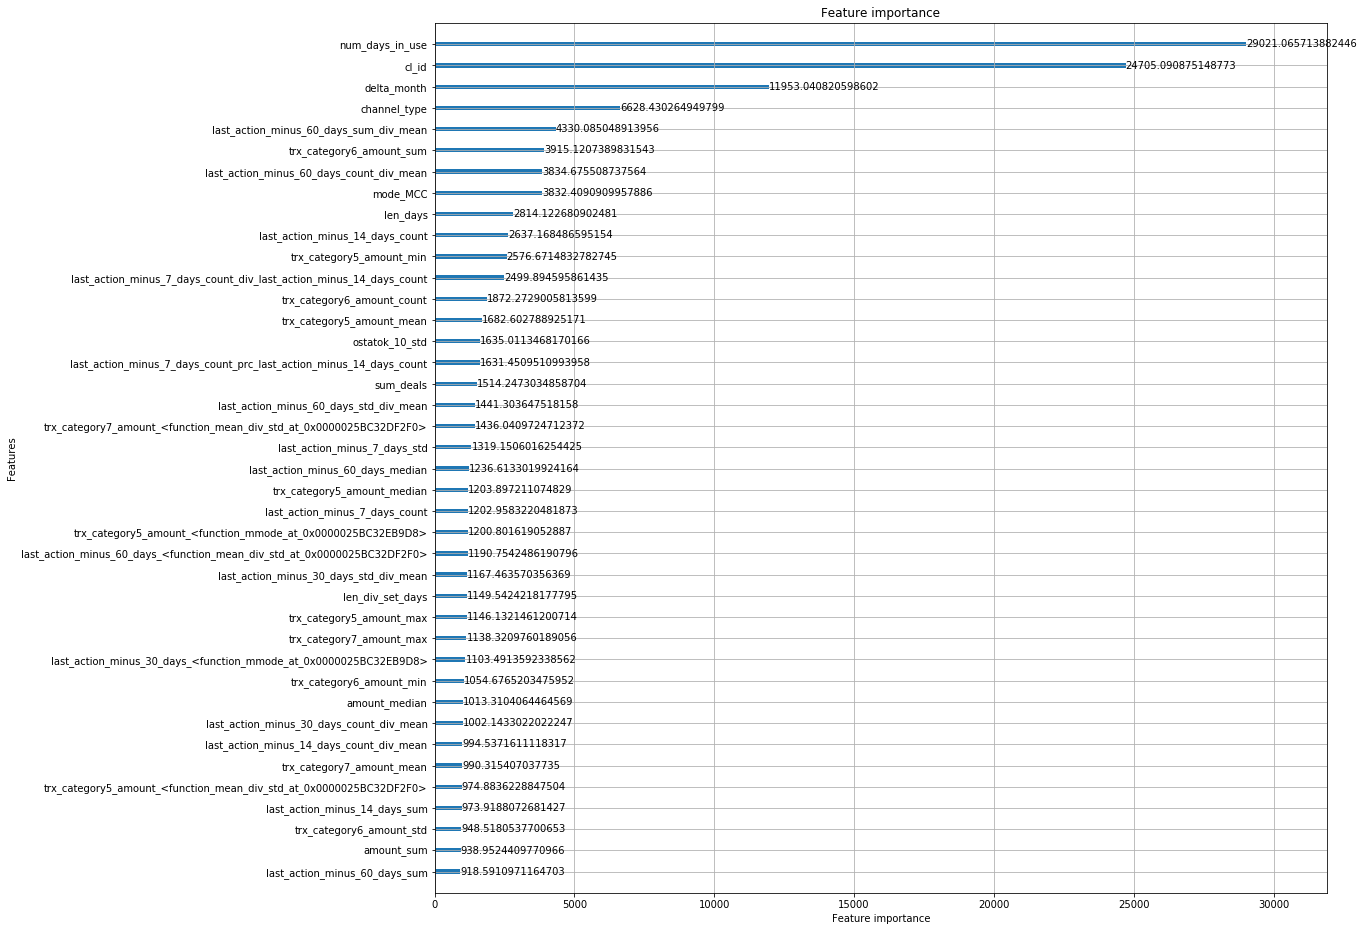

In [45]:
lgb.plot_importance(model, figsize=(16,16), importance_type='gain', max_num_features=40)

# Predict

In [46]:
# 0.8563
y_hat = model.predict(test.drop(['target_flag','target_sum'],axis=1))
sub = pd.DataFrame({
    '_ID_':test['cl_id'],
    '_VAL_': y_hat
})
sub.to_csv('1.csv',index=False)
sub.head()

,_ID_,_VAL_
0,2,0.941546
1,3,0.824599
2,4,0.782936
3,6,0.901844
4,7,0.963668


# Ideas 

* Think about groupby stats 
* Work with MCC - CountVectorizer, Tfidf
* Work with amount as time-series (check tsfresh library)
* Check ideas from similar competition - [SAS & Home Credit Bank](https://sascompetitions.ru/competitions/forecasting-the-probability-of-non-repayment-of-loan) (have to register)